# Airbnb New User Bookings Project

===============================================================

Prepared By:

    1. Ahmed El-Sayed Hamdan - 191035
    2. Mohamed Ahmed Elkhateeb - 191017
    3. Moaaz Youssef Ghonaimy - 191036
    4. Maryam Akram Elghalban - 191084

===============================================================

<pre>
Documenation for the work done:
------------------------------------------------
   <b> 1. Reading the dataset </b>from users and session csvs
   
    <b>2. Preprocessing: </b>
        - Get Sum of sessions per user to be later as a feature
        - Make a join between seesion and users dataframes
        - Cast age to be integer column
        - remove the records for other destination
        
    <b>3.Feature Engineering</b>
        - Check categorical columns and numerical columns
        - fill null with the most frequent vlaue in all columns except age and gender
        - fill gender and age with most frequent value for each distination country so 
          we make that by grouping
        - fill age values with ore than 110 or less than 18 to be most frequent value
        - generate 3 features day, month and year for created acount datetime column
        - generate 3 features day, month and year for first action datetime
        
    <b>4. Classfication</b>
       -  Desciosn Tree Classfier
       -  Random forest Classifer 
            - Change the hyper parameters then test
            - Chceck the features importance and adjust the used features for the model
       - XSBOOST Classfier as an extra classfication to make get the best model for the data
         
    <b>5. Testing using Test dataset </b>
       - Apply the same feature engineering for the testing dataset
       - Fit the model 
       - get the predicitons with <b>probalities</b> which facilitate getting the 5 possible 
         countries by matching the probalitiy value with the lables of countries and ids of
         users
       - sort the probalities and map them to the countries
       - make a for loop to prepare the submission csv file
       
    <b>6. Submit to Kaggle then get the score </b>
       </pre>

===============================================================

### Import Needed Packages

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import datetime
import os

In [2]:
from pyspark.sql.functions import col
from pyspark.sql.functions import split
from pyspark.sql.functions import udf
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import desc
from pyspark.sql.functions import row_number

from pyspark.sql.window import Window

In [3]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### Adding argument to run the jars of XGBOOST classifier which it will be used in classfication later
##### this classfier is not built in in the spark to let it work we need 2 jars file (included in the zip file) and sparkxgb.zip file which also included in the zip file

In [4]:
os.environ['PYSPARK_PYTHON'] = 'python3'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar pyspark-shell'

#### Initialize Spark Session

In [5]:
spark = SparkSession \
    .builder \
    .appName("Airbnb New User Bookings") \
    .getOrCreate()

In [6]:
spark.sparkContext.addPyFile("sparkxgb.zip")

### Reading the Dataset

#### Read Session.csv

In [7]:
sessions = spark.read\
               .format("csv")\
               .option("header", "true")\
               .option("inferSchema","true")\
               .load("input/sessions.csv")

In [8]:
sessions.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- action: string (nullable = true)
 |-- action_type: string (nullable = true)
 |-- action_detail: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- secs_elapsed: double (nullable = true)



In [9]:
sessions.show(5)

+----------+--------------+-----------+-------------------+---------------+------------+
|   user_id|        action|action_type|      action_detail|    device_type|secs_elapsed|
+----------+--------------+-----------+-------------------+---------------+------------+
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       319.0|
|d1mm9tcy42|search_results|      click|view_search_results|Windows Desktop|     67753.0|
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       301.0|
|d1mm9tcy42|search_results|      click|view_search_results|Windows Desktop|     22141.0|
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       435.0|
+----------+--------------+-----------+-------------------+---------------+------------+
only showing top 5 rows



#### Read train_users_2.csv

In [10]:
users = spark.read\
               .format("csv")\
               .option("header", "true")\
               .load("input/train_users_2.csv")

In [11]:
users.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



In [12]:
users.toPandas().head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,None,-unknown-,None,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,None,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


### Feature Engineering

#### cast the age feature to be integer

In [13]:
users = users.withColumn("age", users["age"].cast(IntegerType()))

#### Sum the total session time per user to be used as a feature

In [14]:
sessions = sessions.groupBy('user_id').agg({"secs_elapsed":"sum"})
sessions = sessions.withColumnRenamed("sum(secs_elapsed)", "secs_elapsed")

#### Make a join between session dataframe and user to add the the feature of total sessions for the user

In [15]:
users = users.join(sessions, users.id == sessions.user_id)
users.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- secs_elapsed: double (nullable = true)



#### Ignore the data of country destination to other because it's very small segment

In [16]:
print(users.filter(users['country_destination'] == 'other').count()/users.count())
users = users.filter(users['country_destination'] != 'other')

0.049515681094628464


#### Generate 3 features from date_account_created (year, month, day)


In [17]:
users = users.withColumn('dac_year', split(users.date_account_created, '-')[0])
users = users.withColumn('dac_month', split(users.date_account_created, '-')[1])
users = users.withColumn('dac_day', split(users.date_account_created, '-')[2])
users = users.drop('date_account_created')

# Cast the features to be Integer
users = users.withColumn("dac_year", users["dac_year"].cast(IntegerType()))
users = users.withColumn("dac_month", users["dac_month"].cast(IntegerType()))
users = users.withColumn("dac_day", users["dac_day"].cast(IntegerType()))

#### Generate 3 features from timestamp_first_active (year, month, day)

In [18]:
def get_year_part(date_time_str):
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y%m%d%H%M%S')
    return date_time_obj.year
    
def get_month_part(date_time_str):
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y%m%d%H%M%S')
    return date_time_obj.month
    
def get_day_part(date_time_str):
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y%m%d%H%M%S')
    return date_time_obj.day

get_year_part_udf = udf(get_year_part, IntegerType())
get_month_part_udf = udf(get_month_part, IntegerType())
get_day_part_udf = udf(get_day_part, IntegerType())

users = users.withColumn('tfa_year', get_year_part_udf(users.timestamp_first_active))
users = users.withColumn('tfa_month', get_month_part_udf(users.timestamp_first_active))
users = users.withColumn('tfa_day', get_day_part_udf(users.timestamp_first_active))
users = users.drop('timestamp_first_active')

#### drop unneeded columns

In [19]:
users = users.drop('id','user_id','action','action_type','action_detail','device_type', 'date_first_booking')
users.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- secs_elapsed: double (nullable = true)
 |-- dac_year: integer (nullable = true)
 |-- dac_month: integer (nullable = true)
 |-- dac_day: integer (nullable = true)
 |-- tfa_year: integer (nullable = true)
 |-- tfa_month: integer (nullable = true)
 |-- tfa_day: integer (nullable = true)



#### Get the categorical columns without the GENDER becaseu it filled with another way later

In [20]:
cat_cols = [item[0] for item in users.dtypes if (item[1].startswith('string')) & (item[0] != 'gender')] 
cat_cols

['signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

#### Get the Numerical columns without the AGE becaseu it filled with another way later

In [21]:
num_cols = [item[0] for item in users.dtypes if (item[1].startswith('int') | item[1].startswith('double')) & (item[0] != 'age')] 
num_cols

['secs_elapsed',
 'dac_year',
 'dac_month',
 'dac_day',
 'tfa_year',
 'tfa_month',
 'tfa_day']

#### Get null categorical columns AND fill null with most frequent value

In [22]:
cat_null_cols = [column for column in cat_cols if users.where(col(column).isNull()).count() > 0]
data_noNull = users.na.drop(subset=cat_null_cols)
for column in cat_null_cols:
    data_noNull_per_column = data_noNull.select(column)
    most_frequent = data_noNull_per_column.groupBy(column).count().sort(col("count").desc()).collect()[0][0]
    users = users.na.fill({column:most_frequent})
    print (column,most_frequent)

first_affiliate_tracked untracked


#### Get null numerical columns AND fill null with most frequent value

In [23]:
num_null_cols = [column for column in num_cols if users.filter(col(column).isNull() | col(column).eqNullSafe(0)).count() > 0]
data_noNull = users.na.drop(subset=num_null_cols)
for column in num_null_cols:
    data_noNull_per_column = data_noNull.select(column)
    most_frequent = data_noNull_per_column.groupBy(column).count().sort(col("count").desc()).collect()[0][0]
    users = users.na.fill({column:most_frequent})
    print (column,most_frequent)

secs_elapsed 0.0


#### fill the nulls and -unknown- values for gender columns by most frequent value GROUPED by destination country

In [24]:
gender_noNull = users.filter(users['gender'] != '-unknown-')
grouped_gender = gender_noNull.groupBy('country_destination', 'gender').count()
window_gender = Window.partitionBy("country_destination").orderBy(desc("count"))
grouped_gender = grouped_gender.withColumn('order', row_number().over(window_gender))
grouped_gender = grouped_gender.where(col('order') == 1)

grouped_gender = grouped_gender.withColumnRenamed("gender","gender_ToBeUpdated")
grouped_gender = grouped_gender.withColumnRenamed("country_destination","country_destination_ToBeChecked")
grouped_gender = grouped_gender.drop("count")
grouped_gender = grouped_gender.drop("order")

#### broadcast grouped gender by destination country dataframe with users dataframe

In [25]:
users = users.join(broadcast(grouped_gender), users.country_destination == grouped_gender.country_destination_ToBeChecked)

In [26]:
def change_gender(oldGender, newGender):
    if (oldGender == '-unknown-'):
        return newGender
    return oldGender

change_null_gender = udf(change_gender, StringType())
users = users.withColumn('gender_new', change_null_gender(users.gender, users.gender_ToBeUpdated))

In [27]:
users.select('gender').distinct().show()
users.select('gender_new').distinct().show()

+---------+
|   gender|
+---------+
|     MALE|
|    OTHER|
|-unknown-|
|   FEMALE|
+---------+

+----------+
|gender_new|
+----------+
|      MALE|
|     OTHER|
|    FEMALE|
+----------+



#### fill the nulls and 0 values for age columns by most frequent value GROUPED by destination county

In [28]:
age_noNull = users.filter(users['age'] != 0)
grouped_age = age_noNull.groupBy('country_destination', 'age').count()
window_age = Window.partitionBy("country_destination").orderBy(desc("count"))
grouped_age = grouped_age.withColumn('order', row_number().over(window_age))
grouped_age = grouped_age.where(col('order') == 1)

grouped_age = grouped_age.withColumnRenamed("age","age_ToBeUpdated")
grouped_age = grouped_age.withColumnRenamed("country_destination","country_destination_ToBeChecked2")
grouped_age = grouped_age.drop("count")
grouped_age = grouped_age.drop("order")

#### broadcast grouped AGE by destination country dataframe with users dataframe

In [29]:
users = users.join(broadcast(grouped_age), users.country_destination == grouped_age.country_destination_ToBeChecked2)

In [30]:
users = users.na.fill({'age':0})
users.filter(users['age'] == 0).count()

31300

In [31]:
def change_age(oldAge, newAge):
    if (oldAge == 0):
        return newAge
    return oldAge

change_null_age = udf(change_age, IntegerType())
users = users.withColumn('age_new', change_null_age(users.age, users.age_ToBeUpdated))
users.filter(users['age_new'] == 0).count()

0

#### replace the values less than 18 or greater than 110 to be with most frequent value for age

In [32]:
change_over_age = udf(lambda value: 30 if value>110 else value, IntegerType())
change_under_age = udf(lambda value: 30 if value<18 else value, IntegerType())
users = users.withColumn('age_new', change_over_age(users['age_new']))
users = users.withColumn('age_new', change_under_age(users['age_new']))

#### remove unneeded columns

In [33]:
users =users.drop('gender','age','country_destination_ToBeChecked','gender_ToBeUpdated','country_destination_ToBeChecked2','age_ToBeUpdated')
users.printSchema()

root
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = false)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- secs_elapsed: double (nullable = false)
 |-- dac_year: integer (nullable = true)
 |-- dac_month: integer (nullable = true)
 |-- dac_day: integer (nullable = true)
 |-- tfa_year: integer (nullable = true)
 |-- tfa_month: integer (nullable = true)
 |-- tfa_day: integer (nullable = true)
 |-- gender_new: string (nullable = true)
 |-- age_new: integer (nullable = true)



#### update the array of catogrical columns to contain the gender column

In [34]:
cat_cols = [item[0] for item in users.dtypes if (item[1].startswith('string'))] 

### Prepration for Classification

#### make the label encoding for numerical columns

In [35]:
indexers = [StringIndexer(
    inputCol=column, 
    outputCol=column + '_index', 
    handleInvalid='keep') for column in cat_cols]

#### make one hot encoding for categorical columns

In [36]:
encoders = [OneHotEncoder(
    inputCol=column + '_index', 
    outputCol= column + '_encoded') for column in cat_cols if column not in ['country_destination']]

#### create the pipline

In [37]:
pipeline = Pipeline(stages=indexers + encoders)

#### split the dataset for a training and testing parts

In [38]:
(trainingData, testData) = users.randomSplit([0.8,0.2])

In [39]:
transformedDF = pipeline.fit(trainingData).transform(trainingData)

#### specify the requeired columns to be as features for our model
##### thery are updated after checing the feature importance from random forest classfier

In [40]:
requiredFeatures = [
    'age_new',
    'signup_flow_encoded',
    'gender_new_encoded',
    'signup_method_encoded',
  #  'language_encoded',
  #  'affiliate_channel_encoded',
  #  'affiliate_provider_encoded',
  #  'first_affiliate_tracked_encoded',
  #  'signup_app_encoded',
  #  'first_device_type_encoded',
    'first_browser_encoded',
    'secs_elapsed',
  #  'dac_year',
    'dac_month',
    'dac_day',
  #  'tfa_year',
    'tfa_month',
    'tfa_day'
]

#### create vector assmbler and make transfrom for the data

In [41]:
assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

In [42]:
transformedDF = assembler.transform(transformedDF)

### Decision Tree Classifier

In [43]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'country_destination_index',maxDepth=20)

pipeline = Pipeline(
    stages=indexers + encoders  + [assembler, dt]
)

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# create ealuator
evaluator = MulticlassClassificationEvaluator(
    labelCol="country_destination_index", predictionCol="prediction", metricName="accuracy")

# check the accuracy
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % (accuracy))

Accuracy = 0.677574 


In [44]:
predictions.printSchema()

root
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = false)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- secs_elapsed: double (nullable = false)
 |-- dac_year: integer (nullable = true)
 |-- dac_month: integer (nullable = true)
 |-- dac_day: integer (nullable = true)
 |-- tfa_year: integer (nullable = true)
 |-- tfa_month: integer (nullable = true)
 |-- tfa_day: integer (nullable = true)
 |-- gender_new: string (nullable = true)
 |-- age_new: integer (nullable = true)
 |-- signup_method_index: double (nullable = false)
 |-- signup_flow_index: double (nullable = false)
 |-- language_index: double (nullable = false)
 |-

#### use Random Forest classifier

In [46]:
# Train a RandomForestModel
rf = RandomForestClassifier(
         labelCol='country_destination_index', 
         featuresCol='features',
         maxDepth=20)

pipeline = Pipeline(
    stages=indexers + encoders  + [assembler, rf]
)

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# create ealuator
evaluator = MulticlassClassificationEvaluator(
    labelCol='country_destination_index', 
    predictionCol='prediction', 
    metricName='accuracy')

# check the accuracy
accuracy = evaluator.evaluate(predictions)
print('Accuracy = ', accuracy)

Accuracy =  0.7194115536419089


In [47]:
predictions.printSchema()

root
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = false)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- secs_elapsed: double (nullable = false)
 |-- dac_year: integer (nullable = true)
 |-- dac_month: integer (nullable = true)
 |-- dac_day: integer (nullable = true)
 |-- tfa_year: integer (nullable = true)
 |-- tfa_month: integer (nullable = true)
 |-- tfa_day: integer (nullable = true)
 |-- gender_new: string (nullable = true)
 |-- age_new: integer (nullable = true)
 |-- signup_method_index: double (nullable = false)
 |-- signup_flow_index: double (nullable = false)
 |-- language_index: double (nullable = false)
 |-

#### check the importance of the features

In [48]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

importance = model.stages[-1].featureImportances
ExtractFeatureImp(importance, transformedDF, "features").head(10)

,idx,name,score
0,0,age_new,0.571887
1,44,secs_elapsed,0.083605
13,8,gender_new_encoded_MALE,0.043482
3,46,dac_day,0.037311
16,11,signup_method_encoded_facebook,0.037207
5,48,tfa_day,0.037124
15,10,signup_method_encoded_basic,0.036798
12,7,gender_new_encoded_FEMALE,0.025823
20,15,first_browser_encoded_-unknown-,0.018233
2,45,dac_month,0.016851


#### using XGBooster Classifier

In [49]:
from sparkxgb import XGBoostEstimator
#help (XGBoostEstimator)

In [50]:
# Train a XGBoostEstimator model
xgboost = XGBoostEstimator(
    featuresCol="features", 
    labelCol="country_destination_index", 
    predictionCol="prediction",    
    max_depth=20,
    objective='multi:softprob',
    subsample=0.5,
    colsample_bytree=0.5,
    seed=0,
    num_class=12,
    eval_metric="mlogloss"
)

pipeline = Pipeline(
    stages=indexers + encoders  + [assembler, xgboost]
)

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# create ealuator
evaluator = MulticlassClassificationEvaluator(
    labelCol='country_destination_index', 
    predictionCol='prediction', 
    metricName='accuracy')

# check the accuracy
accuracy = evaluator.evaluate(predictions)
print('Accuracy = ', accuracy)

Accuracy =  0.656691783279512


In [51]:
predictions.printSchema()

root
 |-- signup_method: string (nullable = true)
 |-- signup_flow: string (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = false)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- secs_elapsed: double (nullable = false)
 |-- dac_year: integer (nullable = true)
 |-- dac_month: integer (nullable = true)
 |-- dac_day: integer (nullable = true)
 |-- tfa_year: integer (nullable = true)
 |-- tfa_month: integer (nullable = true)
 |-- tfa_day: integer (nullable = true)
 |-- gender_new: string (nullable = true)
 |-- age_new: integer (nullable = true)
 |-- signup_method_index: double (nullable = false)
 |-- signup_flow_index: double (nullable = false)
 |-- language_index: double (nullable = false)
 |-

### Preparing to test using testing dataset

#### get all the destination with its label encoding to match later from the probality

In [52]:
countryLables = predictions.select('country_destination','country_destination_index').distinct().sort(predictions.country_destination_index)
countryLables.show()

+-------------------+-------------------------+
|country_destination|country_destination_index|
+-------------------+-------------------------+
|                NDF|                      0.0|
|                 US|                      1.0|
|                 FR|                      2.0|
|                 IT|                      3.0|
|                 GB|                      4.0|
|                 ES|                      5.0|
|                 CA|                      6.0|
|                 DE|                      7.0|
|                 NL|                      8.0|
|                 AU|                      9.0|
|                 PT|                     10.0|
+-------------------+-------------------------+



#### Reading the test data

In [53]:
users_test = spark.read\
               .format("csv")\
               .option("header", "true")\
               .load("input/test_users.csv")

#### apply the same feature engineeing which is done for traing dataset except agr and gender filling nulls to be done only with the frequent values

In [54]:
# Make a join between session dataframe and user to add the the feature of total sessions for the user
users_test = users_test.join(sessions, users_test.id == sessions.user_id)
# cast the age feature to be integer
users_test = users_test.withColumn("age", users_test["age"].cast(IntegerType()))

# Generate 3 features from date_account_created (year, month, day)
users_test = users_test.withColumn('dac_year', split(users_test.date_account_created, '-')[0])
users_test = users_test.withColumn('dac_month', split(users_test.date_account_created, '-')[1])
users_test = users_test.withColumn('dac_day', split(users_test.date_account_created, '-')[2])
users_test = users_test.drop('date_account_created')

users_test = users_test.withColumn("dac_year", users_test["dac_year"].cast(IntegerType()))
users_test = users_test.withColumn("dac_month", users_test["dac_month"].cast(IntegerType()))
users_test = users_test.withColumn("dac_day", users_test["dac_day"].cast(IntegerType()))

# Generate 3 features from timestamp_first_active (year, month, day)
users_test = users_test.withColumn('tfa_year', get_year_part_udf(users_test.timestamp_first_active))
users_test = users_test.withColumn('tfa_month', get_month_part_udf(users_test.timestamp_first_active))
users_test = users_test.withColumn('tfa_day', get_day_part_udf(users_test.timestamp_first_active))
users_test = users_test.drop('timestamp_first_active')

users_test = users_test.drop('user_id','action','action_type','action_detail','device_type', 'date_first_booking')

#### get the catorigcal and numerical colums

In [55]:
cat_cols = [item[0] for item in users_test.dtypes if (item[1].startswith('string'))] 
num_cols = [item[0] for item in users_test.dtypes if (item[1].startswith('int') | item[1].startswith('double'))] 

#### check the nulls  for categorical columns  and fill nulls in in theses columns

In [56]:
cat_null_cols = [column for column in cat_cols if users_test.where(col(column).isNull()).count() > 0]
data_noNull = users_test.na.drop(subset=cat_null_cols)
for column in cat_null_cols:
    data_noNull_per_column = data_noNull.select(column)
    most_frequent = data_noNull_per_column.groupBy(column).count().sort(col("count").desc()).collect()[0][0]
    users_test = users_test.na.fill({column:most_frequent})
    print (column,most_frequent)

first_affiliate_tracked untracked


#### check the nulls  for numerical columns  and fill nulls in in theses columns

In [57]:
num_null_cols = [column for column in num_cols if users_test.filter(col(column).isNull() | col(column).eqNullSafe(0)).count() > 0]
data_noNull = users_test.na.drop(subset=num_null_cols)
for column in num_null_cols:
    data_noNull_per_column = data_noNull.select(column)
    most_frequent = data_noNull_per_column.groupBy(column).count().sort(col("count").desc()).collect()[0][0]
    users_test = users_test.na.fill({column:most_frequent})
    print (column,most_frequent)

age 28
secs_elapsed 0.0


#### replace the values less than 18 or greater than 110 to be with most frequent value for age

In [58]:
users_test = users_test.withColumnRenamed('age','age_new')
users_test = users_test.withColumnRenamed('gender','gender_new')

users_test = users_test.withColumn('age_new', change_over_age(users_test['age_new']))
users_test = users_test.withColumn('age_new', change_under_age(users_test['age_new']))

#### fit the model

In [59]:
predictions = model.transform(users_test)

#### get probalities columns which will be used later to get first 5 possible bookings

In [60]:
pro = predictions.select('probabilities').toPandas()

#### get id columns to match with coountry 

In [61]:
id_test = predictions.select('id').toPandas()

#### Taking the 5 classes with highest probabilities

In [63]:
def mapCountryLabel (index):
    if(index == 0):
        return 'NDF'
    elif(index ==1):
        return 'US'
    elif(index ==2):
        return 'FR'
    elif(index ==3):
        return 'IT'
    elif(index ==4):
        return 'GB'
    elif(index ==5):
        return 'ES'
    elif(index ==6):
        return 'CA'
    elif(index ==7):
        return 'DE'
    elif(index ==8):
        return 'NL'
    elif(index ==9):
        return 'AU'
    elif(index ==10):
        return 'PT' 
    
    return 'other'


test_count = int(id_test.count())

ids = []  #list of ids
cts = []  #list of countries
for i in range(test_count):
    if(i % 10000 == 0):
        print(i)
    idx = id_test.iloc[i][0]
    ids += [idx] * 5
    original = pro.iloc[i][0].tolist()
    sortedarr = np.sort(pro.iloc[i][0])[::-1][:5]
    for j in range(5):
        result = original.index(sortedarr[j])
        result = mapCountryLabel(result)
        cts += [result]  #test.select('country_destination').where(test.country_destination_index == result).toPandas().iloc[0][0]

0
10000
20000
30000
40000
50000
60000


#### Generate submission


In [64]:
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub

,id,country
0,ab6t9i0zbh,NDF
1,ab6t9i0zbh,US
2,ab6t9i0zbh,CA
3,ab6t9i0zbh,GB
4,ab6t9i0zbh,FR
...,...,...
308335,6iclyho8bp,US
308336,6iclyho8bp,NDF
308337,6iclyho8bp,DE
308338,6iclyho8bp,CA


In [65]:
sub.to_csv('sub.csv',index=False)

#### Submission to Kaggle then get the total score 
### 0.82872

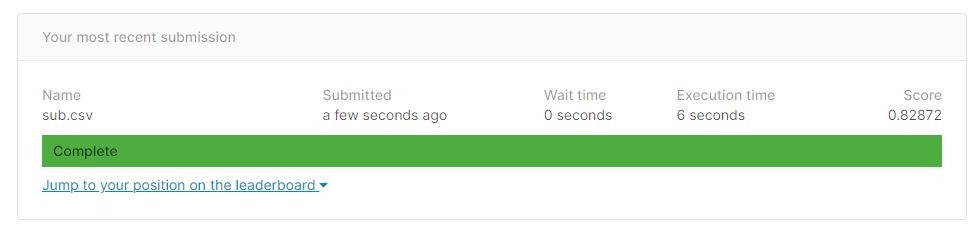

In [66]:
#put a screenshot of the output here
from IPython.display import Image
Image(filename="/home/bitnami/Project/Airbnb/Submission.JPG")

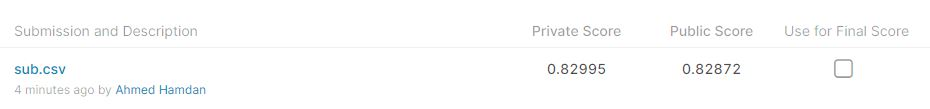

In [67]:
Image(filename="/home/bitnami/Project/Airbnb/Submission2.JPG")